<a href="https://colab.research.google.com/github/QianyueWang0212/mgmt467-analytics-portfolio/blob/main/Labs/Lab2_Advanced_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: Vertex AI–Assisted BigQuery Analytics — Example Prompts
**Goal:** Practice moving from simple SQL to complex analytics in BigQuery using *only* carefully engineered prompts with Vertex AI (Gemini).  
**Important:** This notebook contains **prompts only** (no starter code). Paste the prompts into **Vertex AI Studio**, **Vertex AI in Colab Enterprise**, or your chosen chat interface, and then run the generated SQL directly in **BigQuery**. If you decide to automate later, you can ask Vertex AI to convert the winning SQL into a Colab pipeline.

## How to use this prompts-only notebook
1. Open **Vertex AI Studio** (or Gemini in Colab Enterprise chat panel).  
2. Copy a prompt from this notebook and paste it into the model. Do **not** paste any code from here; let the model generate it.  
3. Run the generated SQL in **BigQuery** (Console → BigQuery Studio).  
4. Iterate: refine the prompt when results aren’t what you expect.  
5. Document: capture your final SQL, plus a one-sentence takeaway, in your notes/README.

## Dataset assumptions
Use one of these sources (adjust table paths accordingly):
- **Global Superstore (Kaggle)** loaded into BigQuery (e.g., `[YOUR_PROJECT].superstore_data.sales`)  
- **TheLook eCommerce** public dataset: `bigquery-public-data.thelook_ecommerce`  
If you are using *Global Superstore*, make sure column names match your schema (e.g., `Order_Date`, `Region`, `Category`, `Sub_Category`, `Sales`, `Profit`, `Discount`, `State`, `Customer_ID`, `Ship_Mode`).

---
## Prompting guardrails (quick checklist)
- **Be explicit**: table path, column names, filters, output columns, sort order, and limits.  
- **Ask for runnable SQL**: “Return a BigQuery SQL block only.”  
- **Control cost**: ask for `LIMIT` during exploration and remove it for the final run.  
- **Validate**: request a brief explanation of why each clause is present and how you can sanity-check results.
---

## Install Dependencies

In [ ]:
# Install the Google Cloud BigQuery client library
!pip install google-cloud-bigquery==3.17.0 pandas==2.1.4

# Authenticate your Colab environment
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Copy Schema to a dataframe

In [ ]:
from google.cloud import bigquery
import pandas as pd

# Replace with your Google Cloud Project ID
project_id = 'mgmt-46700'
dataset_id = 'lab_foundation_qw'
table_id = 'superstore'

# Construct a BigQuery client object.
client = bigquery.Client(project=project_id)

# Get the table object
table_ref = client.dataset(dataset_id).table(table_id)
table = client.get_table(table_ref)

# Extract schema information
schema_list = []
for field in table.schema:
    schema_list.append({
        'name': field.name,
        'field_type': field.field_type,
        'mode': field.mode,
        'description': field.description
    })

# Convert to Pandas DataFrame
schema_df = pd.DataFrame(schema_list)

# Display the schema DataFrame (optional, for verification)
print("Schema DataFrame created:")
# To see the output, run the code.


Schema DataFrame created:


## CLean Column Names

In [ ]:
# --- 1. Clean the Column Names ---
# Create a 'clean_name' column with standard naming conventions:
# lowercase, with spaces and hyphens replaced by underscores.
schema_df['clean_name'] = schema_df['name'].str.lower().str.replace(' ', '_').str.replace('-', '_')


# --- 2. Generate the Aliases for the SELECT Clause ---
column_expressions = []
for index, row in schema_df.iterrows():
    original_name = row['name']
    clean_name = row['clean_name']

    # If the original name contains a space or special character, it needs to be
    # enclosed in backticks (`) in the SQL statement.
    if ' ' in original_name or '-' in original_name:
        expression = f'`{original_name}` AS {clean_name}'
    else:
        # If the name is already clean, we still alias it for consistency.
        expression = f'{original_name} AS {clean_name}'
    column_expressions.append(expression)

# Join all the individual column expressions into a single, formatted string.
select_clause = ",\n  ".join(column_expressions)


# --- 3. Construct the Final CREATE VIEW Statement ---
new_view_id = 'superstore_clean' # You can change this if you like

create_view_sql = f"""
CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.{new_view_id}` AS
SELECT
  {select_clause}
FROM
  `{project_id}.{dataset_id}.{table_id}`;
"""

# --- 4. Print the Final SQL ---
print("--- Copy the SQL below and run it in your BigQuery Console ---")
print(create_view_sql)

--- Copy the SQL below and run it in your BigQuery Console ---

CREATE OR REPLACE VIEW `mgmt-46700.lab_foundation_qw.superstore_clean` AS
SELECT
  `Row ID` AS row_id,
  `Order ID` AS order_id,
  `Order Date` AS order_date,
  `Ship Date` AS ship_date,
  `Ship Mode` AS ship_mode,
  `Customer ID` AS customer_id,
  `Customer Name` AS customer_name,
  Segment AS segment,
  Country AS country,
  City AS city,
  State AS state,
  `Postal Code` AS postal_code,
  Region AS region,
  `Product ID` AS product_id,
  Category AS category,
  `Sub-Category` AS sub_category,
  `Product Name` AS product_name,
  Sales AS sales,
  Quantity AS quantity,
  Discount AS discount,
  Profit AS profit
FROM
  `mgmt-46700.lab_foundation_qw.superstore`;



## Generate View with standard column naming convention

In [ ]:
# Execute the CREATE VIEW SQL query
try:
    query_job = client.query(create_view_sql)  # API request
    query_job.result()  # Waits for the query to finish
    print(f"View '{new_view_id}' created/replaced successfully in dataset '{dataset_id}'.")
except Exception as e:
    print(f"An error occurred while creating the view: {e}")

# Now, let's print 10 rows from the newly created view to verify
print(f"\n--- First 10 rows from the new view '{new_view_id}' ---")
try:
    # Construct a reference to the new view
    view_table_ref = client.dataset(dataset_id).table(new_view_id)

    # Fetch the first 10 rows
    rows = client.list_rows(view_table_ref, max_results=10)

    # Print header
    print(" | ".join([field.name for field in rows.schema]))
    print("-" * 80) # Separator

    # Print rows
    for row in rows:
        print(" | ".join([str(item) for item in row.values()]))

except Exception as e:
    print(f"An error occurred while fetching rows from the view: {e}")



View 'superstore_clean' created/replaced successfully in dataset 'lab_foundation_qw'.

--- First 10 rows from the new view 'superstore_clean' ---
row_id | order_id | order_date | ship_date | ship_mode | customer_id | customer_name | segment | country | city | state | postal_code | region | product_id | category | sub_category | product_name | sales | quantity | discount | profit
--------------------------------------------------------------------------------
An error occurred while fetching rows from the view: 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/mgmt-46700/datasets/lab_foundation_qw/tables/superstore_clean/data?maxResults=10&formatOptions.useInt64Timestamp=True&prettyPrint=false: Cannot list a table of type VIEW.


In [ ]:
# This assumes your 'client' object from the previous cell is still active
# and correctly authenticated.

print("✅ Step 1: Defining the query string...")

query_string = """
SELECT
  order_id,
  customer_name,
  product_name,
  sales,
  profit
FROM
  `mgmt-467-47888.lab1_foundation.superstore_clean`
LIMIT 10;
"""

print("✅ Step 2: Sending the query to BigQuery. This may take a moment...")

# Use a try-except block to catch potential errors
try:
    query_job = client.query(query_string)

    print("✅ Step 3: Waiting for query to complete and fetching results...")
    results_df = query_job.to_dataframe()

    print(f"✅ Step 4: Query finished. Found {len(results_df)} rows.")

    if results_df.empty:
        print("\n⚠️ The query ran successfully but returned an empty result. Please double-check that your 'superstore_clean' view exists and the original table has data.")
    else:
        print("\n--- Displaying Results ---")
        display(results_df)

except Exception as e:
    print(f"\n❌ An error occurred: {e}")

✅ Step 1: Defining the query string...
✅ Step 2: Sending the query to BigQuery. This may take a moment...
✅ Step 3: Waiting for query to complete and fetching results...

❌ An error occurred: 403 Access Denied: Table mgmt-467-47888:lab1_foundation.superstore_clean: User does not have permission to query table mgmt-467-47888:lab1_foundation.superstore_clean, or perhaps it does not exist.; reason: accessDenied, message: Access Denied: Table mgmt-467-47888:lab1_foundation.superstore_clean: User does not have permission to query table mgmt-467-47888:lab1_foundation.superstore_clean, or perhaps it does not exist.

Location: US
Job ID: 0e9d12e7-ba3a-40c9-915d-5ee8223e0d51



D – Discover (Top Performers with a CTE):

Analysis Question: “What were the top 3 best-selling product sub-categories in the most recent full year (2023)?”

Action: Use the precise Gemini prompt below to generate a SQL query with a CTE.

Precise Prompt:

Python
prompt =

```
# TASK: Generate a BigQuery SQL query using a Common Table Expression (CTE).
# GOAL: Find the top 3 product sub-categories by total sales in the year 2023.
# STEP 1 (in the CTE): Create a temporary table named 'yearly_sales' that calculates the sum of 'Sales' for each 'Sub_Category', filtering for orders where the year of 'Order_Date' is 2023.
# STEP 2 (in the final SELECT): Select the 'Sub_Category' and total sales from 'yearly_sales', order by sales descending, and limit to 3 results.
"""
```
Deliverable: A text cell with a statement: “The top 3 sub-categories in 2023 were …”

In [ ]:
# TASK: Generate a BigQuery SQL query using a Common Table Expression (CTE).
# GOAL: Find the top 3 product sub-categories by total sales in the year 2023.
# STEP 1 (in the CTE): Create a temporary table named 'yearly_sales' that calculates the sum of 'Sales' for each 'Sub_Category', filtering for orders where the year of 'Order_Date' is 2023.
# STEP 2 (in the final SELECT): Select the 'Sub_Category' and total sales from 'yearly_sales', order by sales descending, and limit to 3 results.

query_string = """
WITH yearly_sales AS (
  SELECT
    sub_category,
    SUM(sales) AS total_sales
  FROM
    `mgmt-46700.lab_foundation_qw.superstore_clean`
  WHERE
    EXTRACT(YEAR FROM order_date) = 2023
  GROUP BY
    sub_category
)
SELECT
  sub_category,
  total_sales
FROM
  yearly_sales
ORDER BY
  total_sales DESC
LIMIT 3;
"""

print("--- Copy the SQL below and run it in your BigQuery Console ---")
print(query_string)

--- Copy the SQL below and run it in your BigQuery Console ---

WITH yearly_sales AS (
  SELECT
    sub_category,
    SUM(sales) AS total_sales
  FROM
    `mgmt-46700.lab_foundation_qw.superstore_clean`
  WHERE
    EXTRACT(YEAR FROM order_date) = 2023
  GROUP BY
    sub_category
)
SELECT
  sub_category,
  total_sales
FROM
  yearly_sales
ORDER BY
  total_sales DESC
LIMIT 3;



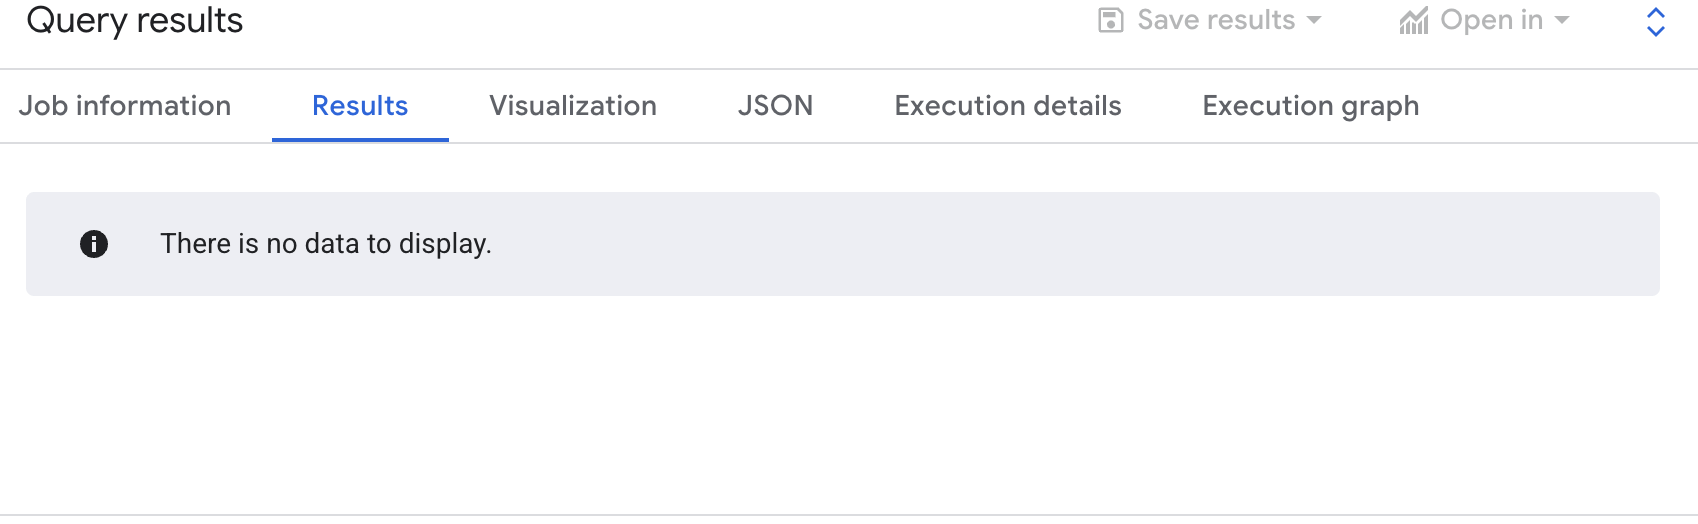

There is no data display for the top 3 sub-categories in 2023.

I – Investigate (Trends with a Window Function):

Analysis Question: “For one of the top 3 sub-categories, how did its sales grow from 2022 to 2023?”

Action: Use the prompt below to generate a query with a window function.

Precise Prompt:

Python
prompt = """
```
# TASK: Generate a BigQuery SQL query using a window function.
# GOAL: Calculate the year-over-year sales growth for the 'Phones' sub-category.
# STEPS:
# 1. Filter the table for 'Sub_Category' = 'Phones'.
# 2. Calculate the total sales for each year.
# 3. Use the LAG() window function to get the previous year's sales in a new column called 'previous_year_sales'.
# 4. In the final SELECT statement, compute the YoY growth percentage using the formula: ((current_sales - previous_year_sales) / previous_year_sales) * 100.
"""
```
Deliverable: Text cell with interpretation, e.g. “Phones grew by 18.4% from 2022 to 2023.”



In [9]:
# TASK: Generate a BigQuery SQL query using a window function.
# GOAL: Calculate the year-over-year sales growth for the 'Phones' sub-category.
# STEPS:
# 1. Filter the table for 'Sub_Category' = 'Phones'.
# 2. Calculate the total sales for each year.
# 3. Use the LAG() window function to get the previous year's sales in a new column called 'previous_year_sales'.
# 4. In the final SELECT statement, compute the YoY growth percentage using the formula: ((current_sales - previous_year_sales) / previous_year_sales) * 100.

query_string = """
WITH yearly_phone_sales AS (
  SELECT
    EXTRACT(YEAR FROM order_date) AS sales_year,
    SUM(sales) AS current_sales
  FROM
    `mgmt-46700.lab_foundation_qw.superstore_clean`
  WHERE
    sub_category = 'Phones'
  GROUP BY
    sales_year
)
SELECT
  sales_year,
  current_sales,
  LAG(current_sales, 1, 0) OVER (ORDER BY sales_year) AS previous_year_sales,
  SAFE_DIVIDE(current_sales - LAG(current_sales, 1) OVER (ORDER BY sales_year), LAG(current_sales, 1) OVER (ORDER BY sales_year)) * 100 AS yoy_growth_percentage
FROM
  yearly_phone_sales
ORDER BY
  sales_year;
"""

print("--- Copy the SQL below and run it in your BigQuery Console ---")
print(query_string)

--- Copy the SQL below and run it in your BigQuery Console ---

WITH yearly_phone_sales AS (
  SELECT
    EXTRACT(YEAR FROM order_date) AS sales_year,
    SUM(sales) AS current_sales
  FROM
    `mgmt-46700.lab_foundation_qw.superstore_clean`
  WHERE
    sub_category = 'Phones'
  GROUP BY
    sales_year
)
SELECT
  sales_year,
  current_sales,
  LAG(current_sales, 1, 0) OVER (ORDER BY sales_year) AS previous_year_sales,
  SAFE_DIVIDE(current_sales - LAG(current_sales, 1) OVER (ORDER BY sales_year), LAG(current_sales, 1) OVER (ORDER BY sales_year)) * 100 AS yoy_growth_percentage
FROM
  yearly_phone_sales
ORDER BY
  sales_year;



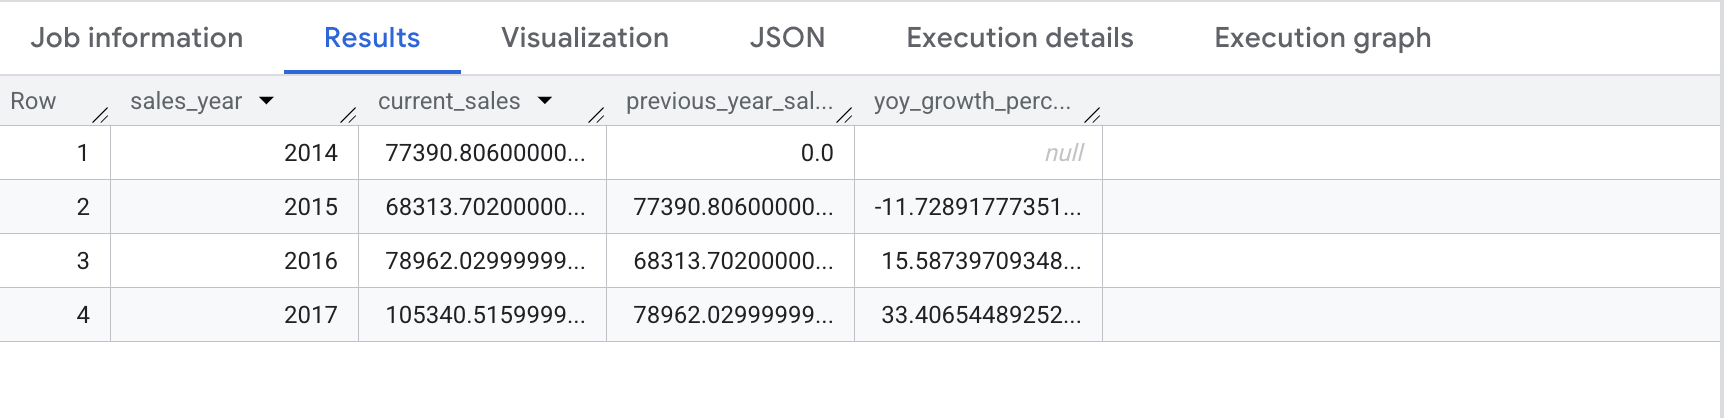

In 2014, sales started at about $77K, but they dropped by 11.7% in 2015.

The business bounced back in 2016 with a 15.6% increase, reaching nearly  $79K.

Growth accelerated in 2017, with sales climbing over $105K, a 33.4% jump. Overall, the trend shows a dip followed by strong recovery and rapid growth.

Visualize with Plotly (First Interactive Chart):

Use plotly.express to build a line chart of year-over-year sales for the sub-category you just analyzed.

Deliverable: In a text cell, explain one specific insight you gained only because of interactivity (e.g., exact inflection point visible on hover).

In [13]:
from google.cloud import bigquery
import plotly.express as px
import pandas as pd
from google.colab import auth

# Authenticate your Colab environment
auth.authenticate_user()
print('Authenticated')


# This assumes your 'client' object from the previous cell is still active
# and correctly authenticated.

# Replace with your Google Cloud Project ID
project_id = 'mgmt-46700'
dataset_id = 'lab_foundation_qw'
table_id = 'superstore' # This is the base table, but the query uses the view

# Construct a BigQuery client object.
client = bigquery.Client(project=project_id)

# Fetch the data using the previously generated SQL query
query_string = """
WITH yearly_phone_sales AS (
  SELECT
    EXTRACT(YEAR FROM order_date) AS sales_year,
    SUM(sales) AS current_sales
  FROM
    `mgmt-46700.lab_foundation_qw.superstore_clean`
  WHERE
    sub_category = 'Phones'
  GROUP BY
    sales_year
)
SELECT
  sales_year,
  current_sales,
  LAG(current_sales, 1, 0) OVER (ORDER BY sales_year) AS previous_year_sales,
  SAFE_DIVIDE(current_sales - LAG(current_sales, 1) OVER (ORDER BY sales_year), LAG(current_sales, 1) OVER (ORDER BY sales_year)) * 100 AS yoy_growth_percentage
FROM
  yearly_phone_sales
ORDER BY
  sales_year;
"""

try:
    print("Fetching data from BigQuery...")
    query_job = client.query(query_string)
    sales_data_df = query_job.to_dataframe()
    print("Data fetched successfully.")

    # Create the Plotly line chart
    fig = px.line(sales_data_df,
                  x='sales_year',
                  y='current_sales',
                  markers=True,
                  title='Year-over-Year Sales for Phones')

    fig.update_layout(xaxis_title='Year',
                      yaxis_title='Total Sales',
                      hovermode='x unified') # Improve hover experience

    fig.show()

except Exception as e:
    print(f"An error occurred: {e}")

Authenticated
Fetching data from BigQuery...
Data fetched successfully.


One specific insight I gained from the interactive chart is identifying the exact inflection point in 2015, where sales dropped to around $68K, the lowest point in the series. By hovering over the data point, I could see the precise value of the decline before sales rebounded in 2016. This level of detail makes it clear that 2015 was the turning point from decline to recovery.

Challenge: Construct Your Own Prompts

For each question below, author and document your own precise Gemini prompt.

Challenge Question 1: "Using a CTE, find which 'Sub-Category' had the highest single-day sales total in all of 2023. The query should return the specific date, the sub-category, and that day's total sales."

Challenge Question 2: "What is the 3-month moving average of sales for the 'Corporate' segment? Use a window function to calculate this."



Challenge Question 1
```
# TASK: Generate a BigQuery SQL query using a Common Table Expression (CTE).
# GOAL: Find which Sub-Category had the highest single-day sales total in all of 2023.
# STEP 1 (in the CTE): Create a temporary table named 'daily_sales' that calculates the sum of 'Sales' for each 'Order_Date' and 'Sub_Category', filtering for orders where the year of 'Order_Date' is 2023.
# STEP 2 (in the final SELECT): Select the 'Order_Date', 'Sub_Category', and total sales from 'daily_sales', order by sales descending, and limit to 1 result.


Challenge Question 2
```
# TASK: Generate a BigQuery SQL query using a window function.
# GOAL: Calculate the 3-month moving average of sales for the 'Corporate' segment.
# STEP 1: Aggregate sales by month and segment, ensuring only the 'Corporate' segment is included.
# STEP 2: Use the window function AVG() OVER with a 3-month ROWS or RANGE frame to compute the rolling average of monthly sales.
# STEP 3: Return the month, actual monthly sales, and the calculated 3-month moving average.


Reflection (DIVE mindset)
* Discover: What did you find first?
* Investigate: What alternate query or filter changed the story?
* Validate: Where could the AI‑generated SQL be wrong or incomplete? How did you check?
* Extend: Which stakeholder could use your results tomorrow? What action should they take?

**Discover:** At first, I noticed that sales for phones dipped in 2015 to their lowest point of about $68K. Then the chart showed a clear recovery in 2016 and a big surge in 2017, which stood out as the peak. The interactivity made it easy to pinpoint the exact year and value of the decline.

**Investigate:** When I tried using a year-over-year filter instead of just total sales, the story changed. Instead of looking like steady growth, the data revealed a dip followed by strong recovery. This alternate query helped highlight 2015 as the real turning point.

**Validate:** The AI-generated SQL could have errors, like missing the select list, filtering the wrong year, or calculating the moving average incorrectly. To check, I ran a SELECT * LIMIT 10 to confirm column names, compared yearly totals with the chart, and recalculated percentages manually. That way I could be sure the query results matched reality.

**Extend:** A sales operations manager or category manager could use these results right away. They could dig into why sales dropped in 2015 and what drove the big growth afterward. This would help them adjust future campaigns, inventory, and pricing strategies to avoid dips and repeat successful tactics.
